In [1]:
from matplotlib import pyplot as plt
import numpy as np
import math

import sys
sys.path.append('../scripts/code')

from pce import PCE
import distribution as distr
from test_functions_a import *

%matplotlib inline

In [2]:
exp_name = 'experiments/test_accuracy_new_4_'
save_all = True 

In [3]:
seed = 0
np.random.seed(seed)

In [4]:
n_test = 10**6 

## Experiment: Sobol g-function

In [5]:
# 


#  =======================================================================
# Define Sobol g-function

sobol_a =  [0.0, 4.0] #[0.0, 1.0, 3.5]        #[1.7, 1.5, 0.5, 0.0, 1.0, 2.5, 0.0, 0.5, 0.7, 1] #  [0.0, 0.1]#  #[0.0, 0.5, 0.7, 1] #  # #  # [0, 0.5, 0.7, 1] #  
#a = [1.7, 1.5, 0.5, 0.0, 1.0, 2.5, 0.0, 0.5, 0.7, 1]

def function(X):
    return sobol_g_func(sobol_a, X)[:, np.newaxis]

dim = len(sobol_a)
lb = -1.0
ub = 1.0

true_Sobol_indices = get_indices_sobol_g_func(sobol_a, full=True)


#  ==================================================================
# Approximation setting

total_degree = 20
q_norm = 0.5


#  ==================================================================
# Experiment setting

start_power = 1.960 #2
end_power = 6 #4 # training sample size = 10^end_power
num = 110 #!!! 5

function_name = 'Sobol'

In [6]:
exp_name += function_name

## Experiment: test

In [7]:
print('main:', true_Sobol_indices['main'])
print('total:',true_Sobol_indices['total'])

main: {(1,): 0.9493670886075948, (2,): 0.0379746835443038, (1, 2): 0.012658227848101264}
total: {(1,): 0.962025316455696, (2,): 0.05063291139240506, (1, 2): 0.9999999999999998}


In [35]:
import os
import dill
print(dill.__version__)

db_name = exp_name+'.db'
if os.path.isfile(db_name):
    print('\n=============== Loading %s ======================\n'%db_name)
    dill.load_session(db_name) #!!!
    raise SystemExit("Workspace is loaded.")
else:
    print('Workspace %s not found'%db_name)

0.3.1.1
Workspace experiments/test_accuracy_new_4_Sobol.db not found


### Code

In [12]:
ranges = lb * np.ones((dim, 2))
ranges[:, 0] = ub


test_X = np.random.rand(n_test, dim)
test_X = (ranges[:, 1] - ranges[:, 0]) * test_X + ranges[:, 0]


test_Y = function(test_X)


true_SI_full = true_Sobol_indices['main']
true_TI_full = true_Sobol_indices['total']



groups = tuple(true_SI_full.keys())

S_full = [true_SI_full[g] for g in groups]
T_full = [true_TI_full[g] for g in groups]

# S_full, T_full

In [13]:

basis_truncation = {'total_degree':total_degree, 'q_norm':q_norm}

In [14]:
marginals = distr.Marginals([distr.Uniform(lb, ub)]*dim)

model = PCE(marginals, basis_truncation)

print(model)

print('\nbasis_functions_number:', model._basis_functions_number)

PCE(marginals=Marginals([Uniform(a=-1.0, b=1.0, Legendre), Uniform(a=-1.0, b=1.0, Legendre)]), basis_truncation={'total_degree': 20, 'q_norm': 0.5})

basis_functions_number: 91


In [15]:
indices_full_number = len(groups)

indices_full_number, groups

(3, ((1,), (2,), (1, 2)))

In [16]:
groups

((1,), (2,), (1, 2))

In [18]:
%%time

sample_sizes = np.logspace(start_power, end_power, num=num, endpoint=True, base=10.0, dtype=np.int)
print('sample_sizes', sample_sizes)

rrmse = np.nan * np.ones((len(sample_sizes)))
appr_SI =  np.nan * np.ones((len(sample_sizes), indices_full_number))
appr_TI =  np.nan * np.ones((len(sample_sizes),  indices_full_number))


max_n = max(sample_sizes)
all_X = (ranges[:, 1] - ranges[:, 0]) * np.random.rand(max_n, dim) + ranges[:, 0]
all_Y = function(all_X)


for i, n in enumerate(sample_sizes):
    
    print(i, n)
    
    X = all_X[:n].copy()
    Y = all_Y[:n].copy()


    if model._basis_functions_number <= n:
        model.fit(X, Y, method='ls') # 'projection' 

        rrmse[i] = model.validate(test_X, test_Y)['rrmse']
        full_SI = model.get_sobol_indices(ind_type='main', full=True)
        full_TI = model.get_sobol_indices(ind_type='total', full=True)
        
        appr_SI[i] = [full_SI[g] for g in groups]
        appr_TI[i] = [full_TI[g] for g in groups]
        
    else:
        rrmse[i] = np.nan
        appr_SI[i] = np.nan
        appr_TI[i] = np.nan
        
        
        

sample_sizes [     91      99     108     117     128     139     152     165     180
     196     214     233     253     276     301     328     357     389
     423     461     502     547     596     649     707     770     838
     913     994    1083    1180    1285    1399    1524    1660    1808
    1969    2144    2335    2543    2770    3017    3286    3578    3897
    4245    4623    5035    5483    5972    6504    7083    7715    8402
    9150    9966   10854   11821   12874   14021   15270   16630   18112
   19726   21483   23397   25482   27752   30225   32917   35850   39044
   42522   46311   50437   54930   59824   65154   70959   77281   84166
   91664   99831  108725  118411  128961  140450  152963  166590  181432
  197596  215200  234373  255253  277994  302761  329735  359111  391105
  425949  463897  505226  550237  599259  652647  710792  774118  843085
  918196 1000000]
0 91
1 99
2 108
3 117
4 128
5 139
6 152
7 165
8 180
9 196
10 214
11 233
12 253
13 276
14 301


/home/ivan/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py:2125: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


41 3017
42 3286
43 3578
44 3897
45 4245
46 4623
47 5035
48 5483
49 5972
50 6504
51 7083
52 7715
53 8402
54 9150
55 9966
56 10854
57 11821
58 12874
59 14021
60 15270
61 16630
62 18112
63 19726
64 21483
65 23397
66 25482
67 27752
68 30225
69 32917
70 35850
71 39044
72 42522
73 46311
74 50437
75 54930
76 59824
77 65154
78 70959
79 77281
80 84166
81 91664
82 99831
83 108725
84 118411
85 128961
86 140450
87 152963
88 166590
89 181432
90 197596
91 215200
92 234373
93 255253
94 277994
95 302761
96 329735
97 359111
98 391105
99 425949
100 463897
101 505226
102 550237
103 599259
104 652647
105 710792
106 774118
107 843085
108 918196
109 1000000
CPU times: user 1h 19min 38s, sys: 5min 53s, total: 1h 25min 32s
Wall time: 14min 24s


In [19]:
abs_indices_errors = np.hstack((np.abs(appr_SI - S_full), np.abs(appr_TI - T_full)))

In [20]:
max_abs_indices_errors = np.max(abs_indices_errors, axis=1)
err_S = max_abs_indices_errors
err_S

array([8.78828233e-01, 8.54003475e-01, 1.23507608e-01, 1.64150507e-01,
       1.04371488e-01, 1.09341863e-01, 1.35757920e-03, 3.42971408e-03,
       1.02829302e-03, 1.62425681e-03, 4.85995939e-04, 3.20187150e-04,
       1.08346624e-03, 5.55370067e-04, 1.52235489e-03, 1.97670252e-03,
       1.24609986e-03, 1.86579458e-03, 2.32923778e-03, 2.15351320e-03,
       2.24356681e-03, 2.07305883e-03, 2.03469313e-03, 1.71699961e-03,
       1.28888896e-03, 7.74500264e-04, 5.44298788e-04, 2.96589082e-04,
       2.23961602e-04, 1.86136734e-04, 1.86758688e-04, 1.36655261e-04,
       1.81239931e-04, 2.52972918e-04, 2.70000057e-04, 3.01803087e-04,
       3.66167636e-04, 3.58506468e-04, 3.55363322e-04, 3.24753301e-04,
       3.11361540e-04, 2.83382731e-04, 3.01852019e-04, 2.84566547e-04,
       3.20525710e-04, 3.23522006e-04, 2.61143683e-04, 2.26554204e-04,
       2.43382255e-04, 2.68175910e-04, 2.31651376e-04, 2.10603774e-04,
       2.09724068e-04, 1.98975047e-04, 1.79991804e-04, 1.51508366e-04,
      

In [21]:
sum_indices_errors = np.sum(np.abs(appr_SI - S_full), axis=1)
sum_indices_errors_squared = np.sum(np.abs(appr_SI - S_full)**2, axis=1)

sum_indices_errors, sum_indices_errors_squared

(array([1.75765647e+00, 1.70800695e+00, 2.47015216e-01, 3.28301013e-01,
        2.08742976e-01, 2.18683727e-01, 2.71515840e-03, 6.85942815e-03,
        2.05658603e-03, 3.24851362e-03, 9.71991877e-04, 6.40374301e-04,
        2.16693247e-03, 1.11074013e-03, 3.04470979e-03, 3.95340504e-03,
        2.49219971e-03, 3.73158915e-03, 4.65847555e-03, 4.30702640e-03,
        4.48713361e-03, 4.14611766e-03, 4.06938625e-03, 3.43399922e-03,
        2.57777792e-03, 1.54900053e-03, 1.08859758e-03, 5.93178163e-04,
        4.47923204e-04, 3.72273469e-04, 3.73517376e-04, 2.73310523e-04,
        3.62479861e-04, 5.05945837e-04, 5.40000115e-04, 6.03606174e-04,
        7.32335272e-04, 7.17012936e-04, 7.10726643e-04, 6.49506602e-04,
        6.22723080e-04, 5.66765462e-04, 6.03704039e-04, 5.69133093e-04,
        6.41051421e-04, 6.47044013e-04, 5.22287366e-04, 4.53108408e-04,
        4.86764511e-04, 5.36351820e-04, 4.63302752e-04, 4.21207549e-04,
        4.19448136e-04, 3.97950094e-04, 3.59983609e-04, 3.030167

In [22]:
sample_sizes

array([     91,      99,     108,     117,     128,     139,     152,
           165,     180,     196,     214,     233,     253,     276,
           301,     328,     357,     389,     423,     461,     502,
           547,     596,     649,     707,     770,     838,     913,
           994,    1083,    1180,    1285,    1399,    1524,    1660,
          1808,    1969,    2144,    2335,    2543,    2770,    3017,
          3286,    3578,    3897,    4245,    4623,    5035,    5483,
          5972,    6504,    7083,    7715,    8402,    9150,    9966,
         10854,   11821,   12874,   14021,   15270,   16630,   18112,
         19726,   21483,   23397,   25482,   27752,   30225,   32917,
         35850,   39044,   42522,   46311,   50437,   54930,   59824,
         65154,   70959,   77281,   84166,   91664,   99831,  108725,
        118411,  128961,  140450,  152963,  166590,  181432,  197596,
        215200,  234373,  255253,  277994,  302761,  329735,  359111,
        391105,  425

array([1.75765647e+00, 1.70800695e+00, 2.47015216e-01, 3.28301013e-01,
       2.08742976e-01, 2.18683727e-01, 2.71515840e-03, 6.85942815e-03,
       2.05658603e-03, 3.24851362e-03, 9.71991877e-04, 6.40374301e-04,
       2.16693247e-03, 1.11074013e-03, 3.04470979e-03, 3.95340504e-03,
       2.49219971e-03, 3.73158915e-03, 4.65847555e-03, 4.30702640e-03,
       4.48713361e-03, 4.14611766e-03, 4.06938625e-03, 3.43399922e-03,
       2.57777792e-03, 1.54900053e-03, 1.08859758e-03, 5.93178163e-04,
       4.47923204e-04, 3.72273469e-04, 3.73517376e-04, 2.73310523e-04,
       3.62479861e-04, 5.05945837e-04, 5.40000115e-04, 6.03606174e-04,
       7.32335272e-04, 7.17012936e-04, 7.10726643e-04, 6.49506602e-04,
       6.22723080e-04, 5.66765462e-04, 6.03704039e-04, 5.69133093e-04,
       6.41051421e-04, 6.47044013e-04, 5.22287366e-04, 4.53108408e-04,
       4.86764511e-04, 5.36351820e-04, 4.63302752e-04, 4.21207549e-04,
       4.19448136e-04, 3.97950094e-04, 3.59983609e-04, 3.03016732e-04,
      

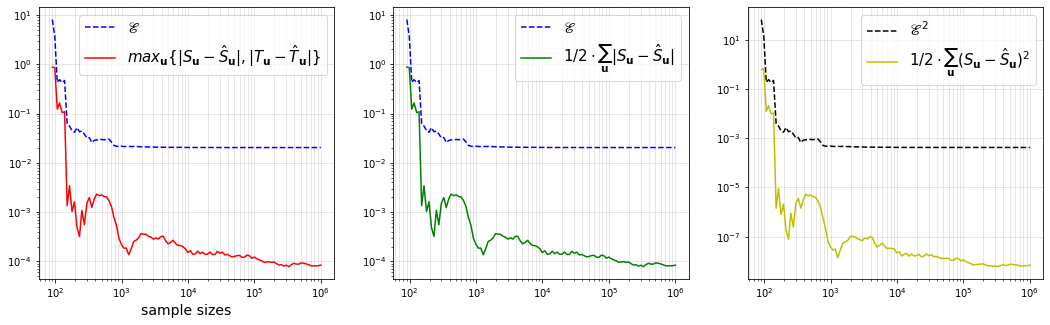

In [55]:
sample_sizes = np.array(sample_sizes)

ind = sample_sizes > 0 # sample_sizes > 500 

plt.figure(figsize=(18, 5))

marker = ''#'o'

fontsize = 15 # legend

plt.subplot(1,3,1)
plt.loglog(sample_sizes[ind], rrmse[ind], label='$\mathscr{E}$',linestyle='--', marker=marker, color='b')
plt.loglog(sample_sizes[ind], err_S[ind], 
           label='$max_\mathbf{u}\{|S_\mathbf{u} - \hat{S}_\mathbf{u}|, |T_\mathbf{u} - \hat{T}_\mathbf{u}|\}$',
           marker=marker, color='r')
plt.legend(loc='best', fontsize=fontsize)
plt.grid(b=True, which='both', color='#999999', axis='x',linestyle='-', alpha=0.3)
plt.grid(b=True, which='major', color='#999999', axis='y',linestyle='-', alpha=0.3)

plt.xlabel('sample sizes', fontsize=14)


#plt.figure(figsize=(12, 5))
plt.subplot(1,3,2)
plt.loglog(sample_sizes[ind], rrmse[ind], label='$\mathscr{E}$',linestyle='--', marker=marker, color='b')
plt.loglog(sample_sizes[ind], 0.5 * sum_indices_errors[ind], 
           label='$1/2 \cdot \sum_\mathbf{u} |S_\mathbf{u} - \hat{S}_\mathbf{u}|$',
           marker=marker, color='g')
plt.legend(loc='best', fontsize=fontsize)
plt.grid(b=True, which='both', color='#999999', axis='x',linestyle='-', alpha=0.3)
plt.grid(b=True, which='major', color='#999999', axis='y',linestyle='-', alpha=0.3)


plt.subplot(1,3,3)
plt.loglog(sample_sizes[ind], rrmse[ind]**2, label='$\mathscr{E}^2$',linestyle='--', marker=marker, 
           color='k')
plt.loglog(sample_sizes[ind],  0.5 *  sum_indices_errors_squared[ind], 
           label='$1/2 \cdot \sum_\mathbf{u} (S_\mathbf{u} - \hat{S}_\mathbf{u})^2$', 
           marker=marker, color='y')
plt.legend(loc='best', fontsize=fontsize)

plt.grid(b=True, which='both', color='#999999', axis='x',linestyle='-', alpha=0.3)
plt.grid(b=True, which='major', color='#999999', axis='y',linestyle='-', alpha=0.3)

if save_all:
    fname = exp_name+'_theoretical.png'
    plt.savefig(fname, dpi=300, bbox_inches='tight', pad_inches=0.05)


sum_indices_errors

In [25]:
exp_name

'experiments/test_accuracy_new_4_Sobol'

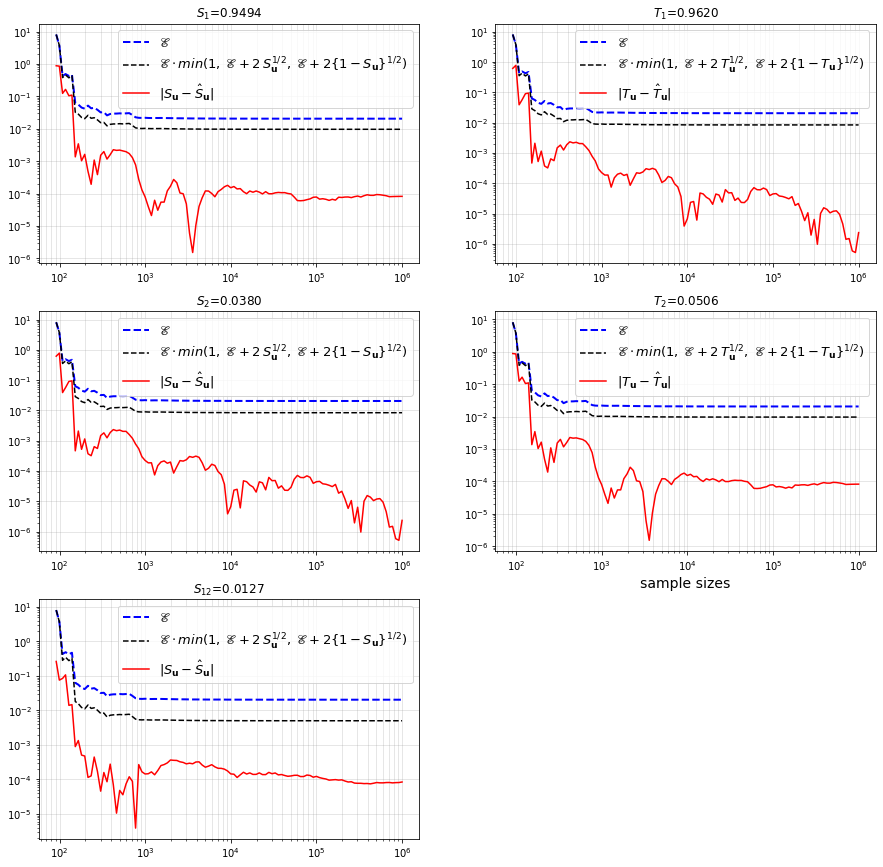

In [53]:
text_groups = ["".join([str(i) for i in g]) for g in groups]


dS = np.abs(appr_SI - S_full)
dT = np.abs(appr_TI - T_full)

marker = ''
fontsize = 13 # legend


ind = sample_sizes > 0 # sample_sizes > 500 

pics_num = appr_SI.shape[1]

plt.figure(figsize=(15, 5*pics_num))
for i in range(pics_num):
    
    # Sobol indices
    
        
    if S_full[i] in [0, 1]:
        label_S = '$\mathscr{E}^2$'
        bound_S = rrmse**2
    
    else:

        label_S = '$ \mathscr{E} \cdot min (1, \; \mathscr{E} + 2 \, S^{1/2}_{\mathbf{u}}, \;  \mathscr{E} + 2 \{1-S_{\mathbf{u}}\}^{1/2} )  $'
        
        temp_min = np.minimum(rrmse + 2 * math.sqrt(S_full[i]),  rrmse + 2 * math.sqrt(max(0, 1-S_full[i])))
        temp_min[temp_min > 1] = 1
        bound_S = temp_min * rrmse

    

    plt.subplot(pics_num, 2, i*2+1)
    plt.title('$S_{{{}}}$={:.4f}'.format(text_groups[i], S_full[i]))

    plt.loglog(sample_sizes[ind], rrmse[ind], label='$\mathscr{E}$',linestyle='--', 
               marker=marker, color='b', linewidth=2)
    plt.loglog(sample_sizes[ind], bound_S[ind], 
               label=label_S,
               linestyle='--', marker=marker, color='k')

    plt.loglog(sample_sizes[ind], dS[ind, i], label='$|S_\mathbf{u} - \hat{S}_\mathbf{u}|$',
            marker=marker, color='r')
    plt.legend(loc='best', fontsize=fontsize)
    
    plt.grid(b=True, which='both', color='#999999', axis='x',linestyle='-', alpha=0.3)
    plt.grid(b=True, which='major', color='#999999', axis='y',linestyle='-', alpha=0.3)
    


    # Total effects
    
    if i == pics_num-1:
        continue

    

    
    if T_full[i] in [0, 1]:
        label_T = '$\mathscr{E}^2$'
        bound_T = rrmse**2
    
    else:
        label_T = '$\mathscr{E} \cdot  min (1, \; \mathscr{E} + 2 \, T^{1/2}_{\mathbf{u}}, \;  \mathscr{E} + 2 \{1-T_{\mathbf{u}}\}^{1/2} )  $'
        
        temp_min = np.minimum(rrmse + 2 * math.sqrt(T_full[i]),  rrmse + 2 * math.sqrt(max(0, 1-T_full[i])))
        temp_min[temp_min > 1] = 1
        bound_T = temp_min * rrmse

        
    plt.subplot(pics_num, 2, i*2+2)
    plt.title('$T_{{{}}}$={:.4f}'.format(text_groups[i], T_full[i]))

    plt.loglog(sample_sizes[ind], rrmse[ind], label='$\mathscr{E}$',linestyle='--', 
               marker=marker, color='b', linewidth=2)
    
    plt.loglog(sample_sizes[ind], bound_T[ind], 
               label=label_T,
               linestyle='--', marker=marker, color='k')
    
    plt.loglog(sample_sizes[ind], dT[ind, i], label='$|T_\mathbf{u} - \hat{T}_\mathbf{u}|$',
              marker=marker, color='r')
    
    plt.legend(loc='best', fontsize=fontsize)
    plt.grid(b=True, which='both', color='#999999', axis='x',linestyle='-', alpha=0.3)
    plt.grid(b=True, which='major', color='#999999', axis='y',linestyle='-', alpha=0.3)
    if i == pics_num-2:
        plt.xlabel('sample sizes', fontsize=14)

if save_all:
    fname = exp_name+'_theoretical_each_u.png'
    plt.savefig(fname, dpi=300, bbox_inches='tight', pad_inches=0.05)

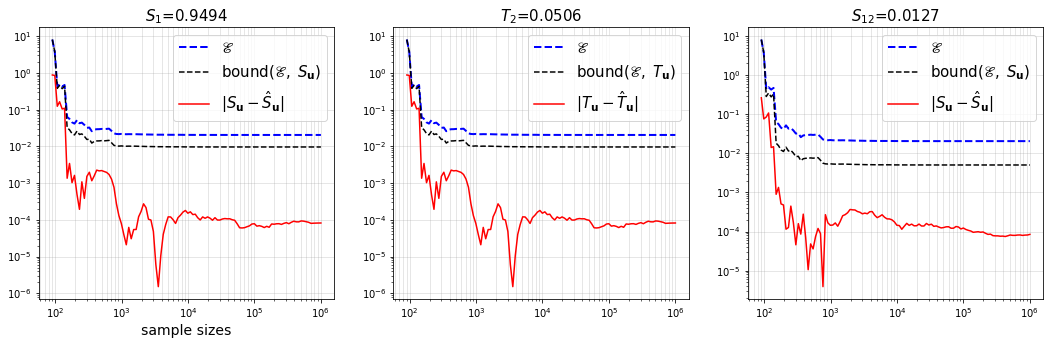

In [58]:
plt.figure(figsize=(18, 5))

selected_pics = [1, 4, 5]


cnt = 1

fontsize = 15 # legend
 
for i in range(pics_num):

    
    if i*2+1 in selected_pics: 
        if S_full[i] in [0, 1]:
            label_S = '$\mathscr{E}^2$'
            bound_S = rrmse**2

        else:

            #label_S = '$ \mathscr{E} \cdot min (1, \; \mathscr{E} + 2 \, S^{1/2}_{\mathbf{u}}, \;  \mathscr{E} + 2 \{1-S_{\mathbf{u}}\}^{1/2} )  $'
            label_S = 'bound$(\mathscr{E}, \; S_{\mathbf{u}})$'

            
            temp_min = np.minimum(rrmse + 2 * math.sqrt(S_full[i]),  rrmse + 2 * math.sqrt(max(0, 1-S_full[i])))
            temp_min[temp_min > 1] = 1
            bound_S = temp_min * rrmse



        plt.subplot(1, len(selected_pics), cnt)
        cnt += 1
        
        plt.title('$S_{{{}}}$={:.4f}'.format(text_groups[i], S_full[i]), fontsize=fontsize)

        plt.loglog(sample_sizes[ind], rrmse[ind], label='$\mathscr{E}$',linestyle='--', 
                   marker=marker, color='b', linewidth=2)
        plt.loglog(sample_sizes[ind], bound_S[ind], 
                   label=label_S,
                   linestyle='--', marker=marker, color='k')

        plt.loglog(sample_sizes[ind], dS[ind, i], label='$|S_\mathbf{u} - \hat{S}_\mathbf{u}|$',
                marker=marker, color='r')
        plt.legend(loc='best', fontsize=fontsize)

        plt.grid(b=True, which='both', color='#999999', axis='x',linestyle='-', alpha=0.3)
        plt.grid(b=True, which='major', color='#999999', axis='y',linestyle='-', alpha=0.3)
        
        if i*2+1 == 1:
            plt.xlabel('sample sizes', fontsize=14)



    # Total effects
    
    if i*2+2 in selected_pics: 
    
        if i == pics_num-1:
            continue

        if T_full[i] in [0, 1]:
            label_T = '$\mathscr{E}^2$'
            bound_T = rrmse**2

        else:
            #label_T = '$\mathscr{E} \cdot  min (1, \; \mathscr{E} + 2 \, T^{1/2}_{\mathbf{u}}, \;  \mathscr{E} + 2 \{1-T_{\mathbf{u}}\}^{1/2} )  $'
            label_T = 'bound$(\mathscr{E}, \; T_{\mathbf{u}})$'
            
            temp_min = np.minimum(rrmse + 2 * math.sqrt(T_full[i]),  rrmse + 2 * math.sqrt(max(0, 1-T_full[i])))
            temp_min[temp_min > 1] = 1
            bound_T = temp_min * rrmse


        #         plt.subplot(pics_num, 2, i*2+2)
        plt.subplot(1, len(selected_pics), cnt)
        cnt += 1
        plt.title('$T_{{{}}}$={:.4f}'.format(text_groups[i], T_full[i]), fontsize=fontsize)

        plt.loglog(sample_sizes[ind], rrmse[ind], label='$\mathscr{E}$',linestyle='--', 
                   marker=marker, color='b', linewidth=2)

        plt.loglog(sample_sizes[ind], bound_T[ind], 
                   label=label_T,
                   linestyle='--', marker=marker, color='k')

        plt.loglog(sample_sizes[ind], dT[ind, i], label='$|T_\mathbf{u} - \hat{T}_\mathbf{u}|$',
                  marker=marker, color='r')

        plt.legend(loc='best', fontsize=fontsize)
        plt.grid(b=True, which='both', color='#999999', axis='x',linestyle='-', alpha=0.3)
        plt.grid(b=True, which='major', color='#999999', axis='y',linestyle='-', alpha=0.3)



if save_all:
    fname = exp_name+'_theoretical_each_u_selected.png'
    plt.savefig(fname, dpi=300, bbox_inches='tight', pad_inches=0.05)

## Practical considerations

In [28]:
%%time


boot_runs = 100 # 100 #!!!
test_portion = 0.15 #0.3 #!!!


std_SI =  np.nan * np.ones((len(sample_sizes), indices_full_number))
std_TI =  np.nan * np.ones((len(sample_sizes),  indices_full_number))

rrmse_emp = np.nan * np.ones((len(sample_sizes)))

for i, n in enumerate(sample_sizes):
    
        
    n_test = int(test_portion * n)
    n_train = n - n_test 
    
    if model._basis_functions_number <= n-n_test:   #len(np.unique(itersample)):
        model.fit(all_X[n_test:n], all_Y[n_test:n], method='ls') # 'projection' 
                
        print(np.std(all_Y[:n_test], axis = 0), math.sqrt(model.get_stats()['variance']))
        max_std = max(np.std(all_Y[:n_test], axis = 0), math.sqrt(model.get_stats()['variance']))
        rrmse_emp[i] = model.validate(all_X[:n_test], all_Y[:n_test])['rmse'] / float(max_std)
        
     
    boot_SI = np.nan * np.ones((boot_runs, indices_full_number))
    boot_TI = np.nan * np.ones((boot_runs, indices_full_number))
    
    for j in range(boot_runs):
        
        print(i, n, j)
        
        itersample = np.random.choice(range(n), size=n, replace=True)  # bootstrap
        #itersample = np.random.choice(range(n_train), size=n_train, replace=False)
        
        X = all_X[:n][itersample].copy()
        Y = all_Y[:n][itersample].copy()
        
        
        if model._basis_functions_number <= len(np.unique(itersample)):  #!!!

            #if model._basis_functions_number <= n:   #len(np.unique(itersample)):
            
            try:
                model.fit(X, Y, method='ls') # 'projection' 
            except:
                continue

            full_SI = model.get_sobol_indices(ind_type='main', full=True)
            full_TI = model.get_sobol_indices(ind_type='total', full=True)

            boot_SI[j] = [full_SI[g] for g in groups]
            boot_TI[j] = [full_TI[g] for g in groups]
            
   
            
    std_SI[i] = np.std(boot_SI, axis=0)
    std_TI[i] = np.std(boot_TI, axis=0)

0 91 0
0 91 1
0 91 2
0 91 3
0 91 4
0 91 5
0 91 6
0 91 7
0 91 8
0 91 9
0 91 10
0 91 11
0 91 12
0 91 13
0 91 14
0 91 15
0 91 16
0 91 17
0 91 18
0 91 19
0 91 20
0 91 21
0 91 22
0 91 23
0 91 24
0 91 25
0 91 26
0 91 27
0 91 28
0 91 29
0 91 30
0 91 31
0 91 32
0 91 33
0 91 34
0 91 35
0 91 36
0 91 37
0 91 38
0 91 39
0 91 40
0 91 41
0 91 42
0 91 43
0 91 44
0 91 45
0 91 46
0 91 47
0 91 48
0 91 49
0 91 50
0 91 51
0 91 52
0 91 53
0 91 54
0 91 55
0 91 56
0 91 57
0 91 58
0 91 59
0 91 60
0 91 61
0 91 62
0 91 63
0 91 64
0 91 65
0 91 66
0 91 67
0 91 68
0 91 69
0 91 70
0 91 71
0 91 72
0 91 73
0 91 74
0 91 75
0 91 76
0 91 77
0 91 78
0 91 79
0 91 80
0 91 81
0 91 82
0 91 83
0 91 84
0 91 85
0 91 86
0 91 87
0 91 88
0 91 89
0 91 90
0 91 91
0 91 92
0 91 93
0 91 94
0 91 95
0 91 96
0 91 97
0 91 98
0 91 99
1 99 0
1 99 1
1 99 2
1 99 3
1 99 4
1 99 5
1 99 6
1 99 7
1 99 8
1 99 9
1 99 10
1 99 11
1 99 12
1 99 13
1 99 14
1 99 15
1 99 16
1 99 17
1 99 18
1 99 19
1 99 20
1 99 21
1 99 22
1 99 23
1 99 24
1 99 25
1 99 26
1 99

In [29]:
len(np.unique(itersample)), len(itersample)

(631701, 1000000)

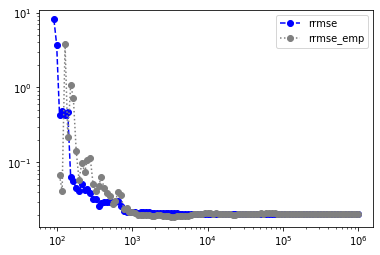

In [30]:
plt.loglog(sample_sizes[ind], rrmse[ind], label='rrmse',linestyle='--', marker='o', color='b')
plt.loglog(sample_sizes[ind], rrmse_emp[ind], label='rrmse_emp',linestyle='dotted', marker='o', color='grey')
plt.legend(loc='best')

In [31]:
appr_SI.shape, sample_sizes.shape

((110, 3), (110,))

/home/ivan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/home/ivan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater


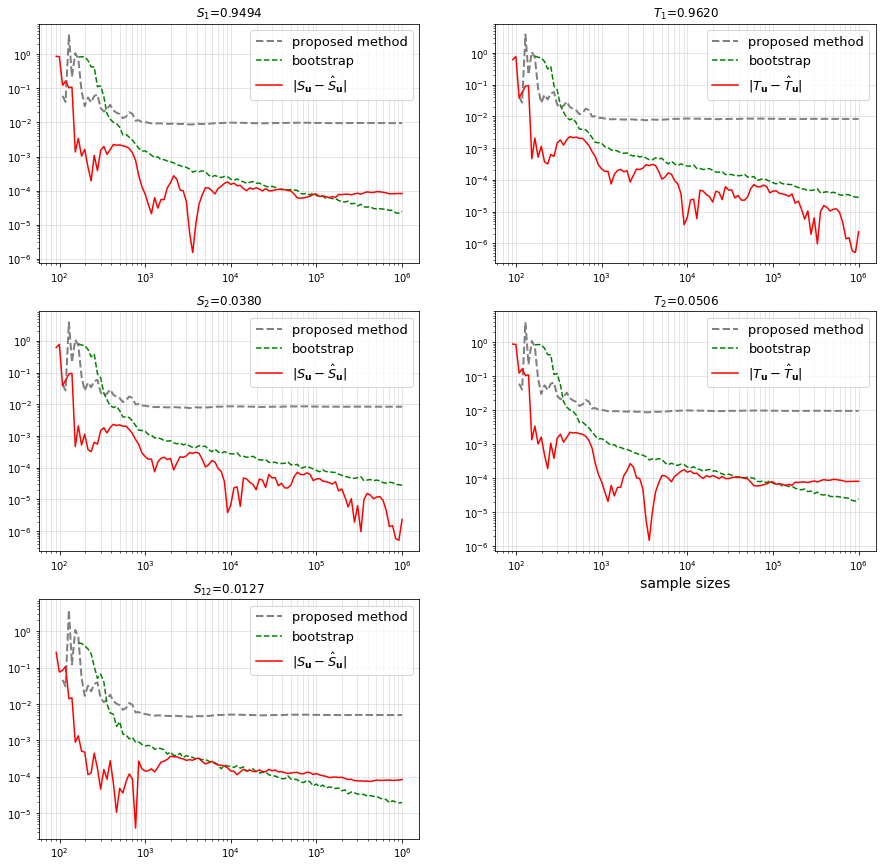

In [49]:
marker = ''


plt.figure(figsize=(15, 5*pics_num))
for i in range(pics_num):
    
    # Sobol indices
    temp_min = np.minimum(rrmse_emp + 2 * np.sqrt(appr_SI[:, i]),  
                          rrmse_emp + 2 * np.sqrt(1-appr_SI[:, i]))
    temp_min[temp_min > 1] = 1
    bound_S_emp = temp_min * rrmse_emp

    plt.subplot(pics_num, 2, i*2+1)
    plt.title('$S_{{{}}}$={:.4f}'.format(text_groups[i], S_full[i]))


    #!!!
    #plt.loglog(sample_sizes[ind], rrmse_emp[ind], label='rrmse_emp',linestyle='dotted', marker='o', color='grey')
    
    
    plt.loglog(sample_sizes[ind], bound_S_emp[ind], label='proposed method',
               linestyle='--', marker=marker, color='grey', linewidth=2)
    
    plt.loglog(sample_sizes[ind], 3*std_SI[ind, i], label='bootstrap',linestyle='--', color='g')
    
    
    plt.loglog(sample_sizes[ind], dS[ind, i], label='$|S_\mathbf{u} - \hat{S}_\mathbf{u}|$', 
               marker=marker, color='r')
    
    plt.legend(loc='best', fontsize=fontsize)
    plt.grid(b=True, which='both', color='#999999', axis='x',linestyle='-', alpha=0.3)
    plt.grid(b=True, which='major', color='#999999', axis='y',linestyle='-', alpha=0.3)

    # Total effects
    
    if i == pics_num-1:
        continue

    temp_min = np.minimum(rrmse_emp + 2 * np.sqrt(appr_TI[:, i]),  
                          rrmse_emp + 2 * np.sqrt(1-appr_TI[:, i]))
    temp_min[temp_min > 1] = 1
    bound_T_emp = temp_min * rrmse_emp


    plt.subplot(pics_num, 2, i*2+2)
    plt.title('$T_{{{}}}$={:.4f}'.format(text_groups[i], T_full[i]))

    plt.loglog(sample_sizes[ind], bound_T_emp[ind], label='proposed method',
               linestyle='--', marker=marker, color='grey', linewidth=2)
        
    plt.loglog(sample_sizes[ind], 3*std_TI[ind, i], label='bootstrap',linestyle='--', color='g')
    
    
    plt.loglog(sample_sizes[ind], dT[ind, i], label='$|T_\mathbf{u} - \hat{T}_\mathbf{u}|$',
                marker=marker, color='r')
    
    plt.legend(loc='best', fontsize=fontsize)
    plt.grid(b=True, which='both', color='#999999', axis='x',linestyle='-', alpha=0.3)
    plt.grid(b=True, which='major', color='#999999', axis='y',linestyle='-', alpha=0.3)

    if i == pics_num-2:
        plt.xlabel('sample sizes', fontsize=14)
        
if save_all:
    fname = exp_name+'_practical_each_u.png'
    plt.savefig(fname, dpi=300)

In [33]:
rrmse_emp, sample_sizes

(array([       nan,        nan, 0.06713885, 0.04155809, 3.83054684,
        0.22155405, 1.08422039, 0.7211398 , 0.14090059, 0.05857586,
        0.0992271 , 0.07432659, 0.10666419, 0.11591802, 0.05209736,
        0.04193722, 0.04888763, 0.06341963, 0.04483481, 0.03889788,
        0.03566507, 0.02744489, 0.03059324, 0.04015736, 0.03631162,
        0.02372693, 0.02440471, 0.02194455, 0.02180306, 0.02092751,
        0.01997838, 0.01985968, 0.02002669, 0.02003918, 0.01964323,
        0.0195252 , 0.0194933 , 0.01978333, 0.01965809, 0.01919238,
        0.01942816, 0.01907928, 0.01860285, 0.01871374, 0.01951944,
        0.01930524, 0.01920247, 0.01937226, 0.01950646, 0.01990163,
        0.02019609, 0.02053506, 0.02045304, 0.02073765, 0.02090027,
        0.02099667, 0.02098718, 0.02069756, 0.02080567, 0.020691  ,
        0.02056053, 0.02049035, 0.02041212, 0.02029988, 0.02012845,
        0.02011108, 0.02023429, 0.02031979, 0.02036039, 0.02053452,
        0.02046199, 0.02036499, 0.02063129, 0.02

/home/ivan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]
/home/ivan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


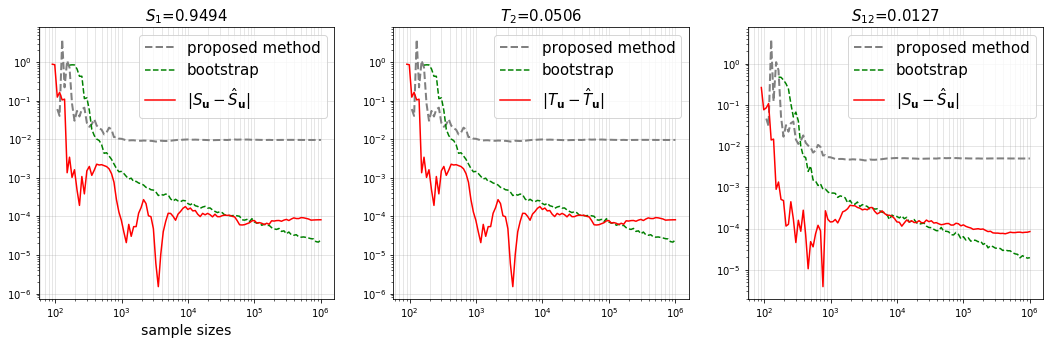

In [61]:
plt.figure(figsize=(18, 5))

cnt = 1


for i in range(pics_num):
    
    if i*2+1 in selected_pics: 
    
        # Sobol indices
        temp_min = np.minimum(rrmse_emp + 2 * np.sqrt(appr_SI[:, i]),  
                              rrmse_emp + 2 * np.sqrt(1-appr_SI[:, i]))
        temp_min[temp_min > 1] = 1
        bound_S_emp = temp_min * rrmse_emp
        
        #         plt.subplot(pics_num, 2, i*2+1)
        plt.subplot(1, len(selected_pics), cnt)
        cnt += 1
        
        plt.title('$S_{{{}}}$={:.4f}'.format(text_groups[i], S_full[i]), fontsize=fontsize)


        #!!!
        #plt.loglog(sample_sizes[ind], rrmse_emp[ind], label='rrmse_emp',linestyle='dotted', marker='o', color='grey')


        plt.loglog(sample_sizes[ind], bound_S_emp[ind], label='proposed method',
                   linestyle='--', marker=marker, color='grey', linewidth=2)

        plt.loglog(sample_sizes[ind], 3*std_SI[ind, i], label='bootstrap',linestyle='--', color='g')


        plt.loglog(sample_sizes[ind], dS[ind, i], label='$|S_\mathbf{u} - \hat{S}_\mathbf{u}|$', 
                   marker=marker, color='r')

        plt.legend(loc='best', fontsize=fontsize)
        plt.grid(b=True, which='both', color='#999999', axis='x',linestyle='-', alpha=0.3)
        plt.grid(b=True, which='major', color='#999999', axis='y',linestyle='-', alpha=0.3)
    
        if i*2+1 == 1:
            plt.xlabel('sample sizes', fontsize=14)



    # Total effects
    
    if i*2+2 in selected_pics: 
    
        temp_min = np.minimum(rrmse_emp + 2 * np.sqrt(appr_TI[:, i]),  
                              rrmse_emp + 2 * np.sqrt(1-appr_TI[:, i]))
        temp_min[temp_min > 1] = 1
        bound_T_emp = temp_min * rrmse_emp


        #         plt.subplot(pics_num, 2, i*2+2)
        plt.subplot(1, len(selected_pics), cnt)
        cnt += 1
        plt.title('$T_{{{}}}$={:.4f}'.format(text_groups[i], T_full[i]), fontsize=fontsize)

        plt.loglog(sample_sizes[ind], bound_T_emp[ind], label='proposed method',
                   linestyle='--', marker=marker, color='grey', linewidth=2)

        plt.loglog(sample_sizes[ind], 3*std_TI[ind, i], label='bootstrap',linestyle='--', color='g')


        plt.loglog(sample_sizes[ind], dT[ind, i], label='$|T_\mathbf{u} - \hat{T}_\mathbf{u}|$',
                    marker=marker, color='r')

        plt.legend(loc='best', fontsize=fontsize)
        plt.grid(b=True, which='both', color='#999999', axis='x',linestyle='-', alpha=0.3)
        plt.grid(b=True, which='major', color='#999999', axis='y',linestyle='-', alpha=0.3)
    
#     if i == pics_num-2:
#         plt.xlabel('sample sizes', fontsize=14)
        
if save_all:
    fname = exp_name+'_practical_each_u_selected.png'
    plt.savefig(fname, dpi=300, bbox_inches='tight', pad_inches=0.05)

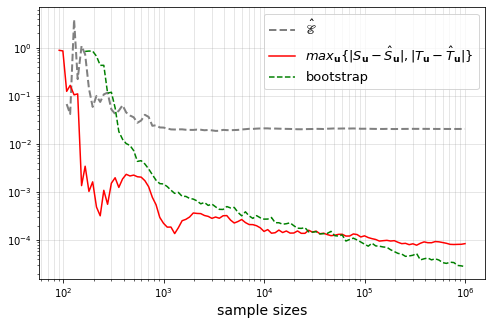

In [50]:
plt.figure(figsize=(8, 5))

plt.loglog(sample_sizes[ind], rrmse_emp[ind], label='$\hat{\mathscr{E}}$', color='grey', marker=marker, linestyle='--',
          linewidth=2) # linestyle='--'

plt.loglog(sample_sizes[ind], err_S[ind], 
           label='$max_\mathbf{u}\{|S_\mathbf{u} - \hat{S}_\mathbf{u}|, |T_\mathbf{u} - \hat{T}_\mathbf{u}|\}$', 
           marker=marker, color='r')

plt.loglog(sample_sizes[ind], 3*np.maximum(np.max(std_SI, axis=1), np.max(std_TI, axis=1))
[ind], label='bootstrap', color='g', marker=marker, linestyle='--') # ,linestyle='--' # '3 * max std_S std_T'


plt.legend(loc='best', fontsize=fontsize)
plt.xlabel('sample sizes', fontsize=14)

plt.grid(b=True, which='both', color='#999999', axis='x',linestyle='-', alpha=0.3)
plt.grid(b=True, which='major', color='#999999', axis='y',linestyle='-', alpha=0.3)

if save_all:
    fname = exp_name+'_practical.png'
    plt.savefig(fname, dpi=300)


In [42]:
del model, test_X, test_Y, X, Y

NameError: name 'test_X' is not defined

In [43]:
import dill
print(dill.__version__)

if os.path.isfile(db_name):
    print('Not saved: file %s already exists'%db_name)
    
else:
    if save_all:
        dill.dump_session(db_name)
        print(db_name, 'is saved')

0.3.1.1
experiments/test_accuracy_new_4_Sobol.db is saved
